In [1]:
import os
import json
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import statistics
import seaborn as sns

from scipy.stats import ttest_ind, shapiro, mannwhitneyu


In [3]:
path = r'corpus_finished_new'

#Load German tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load('de_core_news_md')

def extract_adjectives(text):
    doc = nlp(text)
    return [token.text for token in doc if token.pos_ == 'ADJ']

#Initialize data structures
adjectives_gender = {'m': Counter(), 'w': Counter()}
adjective_ratios_gender = {'m': [], 'w': []}
not_counted = []

#Iterate over .json files
for filename in os.listdir(path):
    if filename.endswith('.json'):
        with open(os.path.join(path, filename), 'r', encoding='utf-8') as f:
            data = json.load(f)
            gender = data['gender']
            poem_text = ' '.join(line['text'] for line in data['poem'].values())
            adjectives = extract_adjectives_lemmata(poem_text)
            try:
                ratio = len(adjectives) / len(poem_text.split())
                adjectives_gender[gender].update(adjectives)
                adjective_ratios_gender[gender].append(ratio)
            except:
                not_counted.append(filename)

#Calculate average adjective ratios for each gender
average_ratios_gender = {gender: sum(ratios) / len(ratios) for gender, ratios in adjective_ratios_gender.items()}

all_genders = sorted(list(average_ratios_gender.keys()))

#Print the overall, median, minimum, and maximum adjective ratio for each gender
for gender in all_genders:
    all_ratios = adjective_ratios_gender[gender]
    print(f'Gender: {gender}')
    print('Overall average relative adjective ratio:', sum(all_ratios) / len(all_ratios))
    print('Median relative adjective ratio:', statistics.median(all_ratios))
    print('Minimum relative adjective ratio:', min(all_ratios))
    print('Maximum relative adjective ratio:', max(all_ratios), '\n')
#Print the 10 most common adjectives for each gender
for gender in all_genders:
    print(f'Gender: {gender}')
    print('10 most common adjectives:', adjectives_gender[gender].most_common(10), '\n')

print(not_counted)

KeyboardInterrupt: 

In [ ]:
len(not_counted)

55

In [ ]:
# Funktion zum Durchführen des Shapiro-Wilk-Tests und zur Interpretation der Ergebnisse
def test_normality(data, sample_name):
    stat, p_value = shapiro(data)
    alpha = 0.05  # Signifikanzniveau
    print(f"Shapiro-Wilk-Test für {sample_name}:")
    print("Teststatistik:", stat)
    print("p-Wert:", p_value)
    if p_value > alpha:
        print(f"Die Adjektivfrequenzen für {sample_name} sind normalverteilt.")
    else:
        print(f"Die Adjektivfrequenzen für {sample_name} sind nicht normalverteilt.")

# Durchführung des Tests für beide Subsamples
test_normality(adjective_ratios_gender['m'], "Sample M")
test_normality(adjective_ratios_gender['w'], "Sample W")

Shapiro-Wilk-Test für Sample M:
Teststatistik: 0.9395573735237122
p-Wert: 6.376049124691613e-24
Die Adjektivfrequenzen für Sample M sind nicht normalverteilt.
Shapiro-Wilk-Test für Sample W:
Teststatistik: 0.9392551183700562
p-Wert: 1.801250148825632e-19
Die Adjektivfrequenzen für Sample W sind nicht normalverteilt.


In [ ]:
# Perform a t-test to compare the means of the two groups
t_stat, p_val = ttest_ind(adjective_ratios_gender['m'], adjective_ratios_gender['w'])

print('T-statistic:', t_stat)
print('p-value:', p_val)

T-statistic: -4.395903717918427
p-value: 1.1506244287424415e-05


In [ ]:
u_stat, p_val = mannwhitneyu(adjective_ratios_gender['m'], adjective_ratios_gender['w'], alternative='two-sided')

print('Mann-Whitney U-Statistik:', u_stat)
print('p-Wert:', p_val)

Mann-Whitney U-Statistik: 640677.5
p-Wert: 7.619898846782165e-05


In [ ]:
n1 = len(adjective_ratios_gender['m'])
n2 = len(adjective_ratios_gender['w'])
effect_size = np.sqrt(u_stat / (n1 * n2))

print("Effektstärke (Cramer's V):", effect_size)

Effektstärke (Cramer's V): 0.6728313565064518


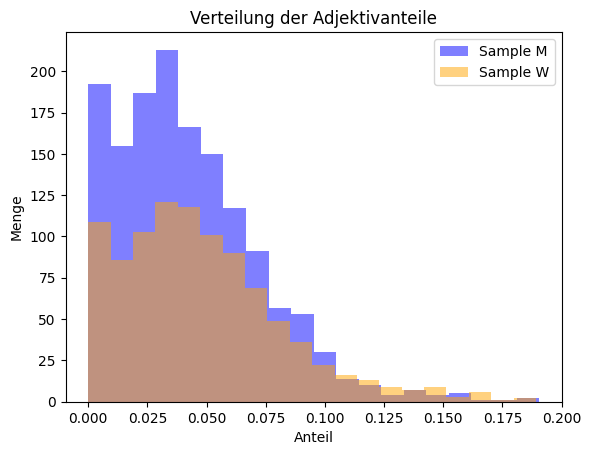

In [ ]:
# Erstelle eine Figure und Axes-Objekte
fig, ax = plt.subplots()

# Plotten der Histogramme für beide Subsamples
ax.hist(adjective_ratios_gender['m'], bins=20, alpha=0.5, label='Sample M', color='blue')
ax.hist(adjective_ratios_gender['w'], bins=20, alpha=0.5, label='Sample W', color='orange')

# Hinzufügen von Labels und Titeln
ax.set_xlabel('Anteil')
ax.set_ylabel('Menge')
ax.set_title('Verteilung der Adjektivanteile')

# Legende anzeigen
ax.legend()

# Anzeigen der Grafik
plt.show()